In [1]:
import pandas as pd
import numpy as np
import polars as pl
import glob
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from src.metrics import *
from src.gen_cand_utils import *
from src.validation import validate_recommendations, plot_metrics_by_k

from datetime import datetime, timedelta
import os

In [2]:
tracker_files = glob.glob('data/final_apparel_tracker_data_08_action_widget/*/*.parquet')
order_files = glob.glob('data/final_apparel_orders_data_07/*/*.parquet')
test_user_ids = pd.read_parquet('data/ml_ozon_recsys_test.snappy.parquet')
test_user_ids_set = set(test_user_ids['user_id'].to_list())
temp_files = glob.glob('tracker_v_2/*.parquet')

In [3]:
test_start = pl.datetime(2025, 7, 1)

In [4]:
all_dfs = []
for i in tqdm(range(len(order_files)), desc='Processing files'):
    file_path = order_files[i]

    df = pl.read_parquet(
        file_path, 
        columns=['user_id', 'item_id', 'created_timestamp', 'last_status', 'last_status_timestamp']
    ).filter((pl.col('created_timestamp') > test_start) & 
             (pl.col('last_status') == 'delivered_orders'))
    
    all_dfs.append(df)

test_orders = pl.concat(all_dfs)

test_orders_true = (
    test_orders
    .group_by("user_id")
    .agg([
        pl.col("item_id").alias("item_ids")
    ]).select(['user_id', 'item_ids'])
).to_pandas()

Processing files: 100%|██████████| 33/33 [00:00<00:00, 34.98it/s] 


## Popular

In [21]:
min_date = pl.datetime(2025, 6, 1)
max_date = pl.datetime(2025, 7, 1)
orders_df = (
    pl.scan_parquet(order_files, extra_columns='ignore')
    .filter((pl.col('created_timestamp') > min_date) &
            (pl.col('created_timestamp') < max_date)) 
    .select(['user_id', 'item_id', 'last_status'])
    .collect()
    )
popular_items = (
    orders_df.filter(pl.col('last_status') == 'delivered_orders')
    .get_column('item_id')
    .value_counts(sort=True)
    .head(100)
    .get_column('item_id')
    .to_list()
    )

In [22]:
candidates = orders_df['user_id'].unique()
candidates = orders_df.select(pl.col('user_id').unique())
candidates = candidates.with_columns(
    pl.lit(popular_items).alias('item_id')
).to_pandas()

,user_id,item_id
0,1,"[51974017, 187052809, 175287070, 247423473, 11..."
1,11,"[51974017, 187052809, 175287070, 247423473, 11..."
2,20,"[51974017, 187052809, 175287070, 247423473, 11..."
3,21,"[51974017, 187052809, 175287070, 247423473, 11..."
4,30,"[51974017, 187052809, 175287070, 247423473, 11..."
...,...,...
520361,5061661,"[51974017, 187052809, 175287070, 247423473, 11..."
520362,5061670,"[51974017, 187052809, 175287070, 247423473, 11..."
520363,5061671,"[51974017, 187052809, 175287070, 247423473, 11..."
520364,5061680,"[51974017, 187052809, 175287070, 247423473, 11..."


In [8]:
test_orders_true

,user_id,item_ids
0,4919701,"[16204463, 185162187, 200405226, 255650318]"
1,3196281,"[228334257, 642078, 103929699, 308515171, 9581..."
2,2748491,[320712742]
3,631301,[57376269]
4,1477160,"[64439414, 250873291]"
...,...,...
217700,1015850,[278632869]
217701,2201331,"[284826418, 20793696, 187992902]"
217702,3196751,[97625584]
217703,3704840,[43748650]


In [ ]:
aggregated_results, _ = validate_recommendations(candidates, test_orders_true, k_values=[100])

Обрабатываю дату: 2025-04-15
nDCG@100 = 0.00582
R@100 = 0.01701
Обрабатываю дату: 2025-04-20
nDCG@100 = 0.00584
R@100 = 0.01703
Обрабатываю дату: 2025-04-25
nDCG@100 = 0.00584
R@100 = 0.01696
Обрабатываю дату: 2025-04-30
nDCG@100 = 0.00583
R@100 = 0.01700
Обрабатываю дату: 2025-05-05
nDCG@100 = 0.00606
R@100 = 0.01772
Обрабатываю дату: 2025-05-10
nDCG@100 = 0.00605
R@100 = 0.01754
Обрабатываю дату: 2025-05-15
nDCG@100 = 0.00613
R@100 = 0.01760
Обрабатываю дату: 2025-05-20
nDCG@100 = 0.00606
R@100 = 0.01732
Обрабатываю дату: 2025-05-25
nDCG@100 = 0.00622
R@100 = 0.01838
Обрабатываю дату: 2025-05-30
nDCG@100 = 0.00626
R@100 = 0.01811
Обрабатываю дату: 2025-06-04
nDCG@100 = 0.00607
R@100 = 0.01773
Обрабатываю дату: 2025-06-09
nDCG@100 = 0.00564
R@100 = 0.01634
Обрабатываю дату: 2025-06-14
nDCG@100 = 0.00515
R@100 = 0.01494
Обрабатываю дату: 2025-06-19
nDCG@100 = 0.00438
R@100 = 0.01258
Обрабатываю дату: 2025-06-24
nDCG@100 = 0.00324
R@100 = 0.00931


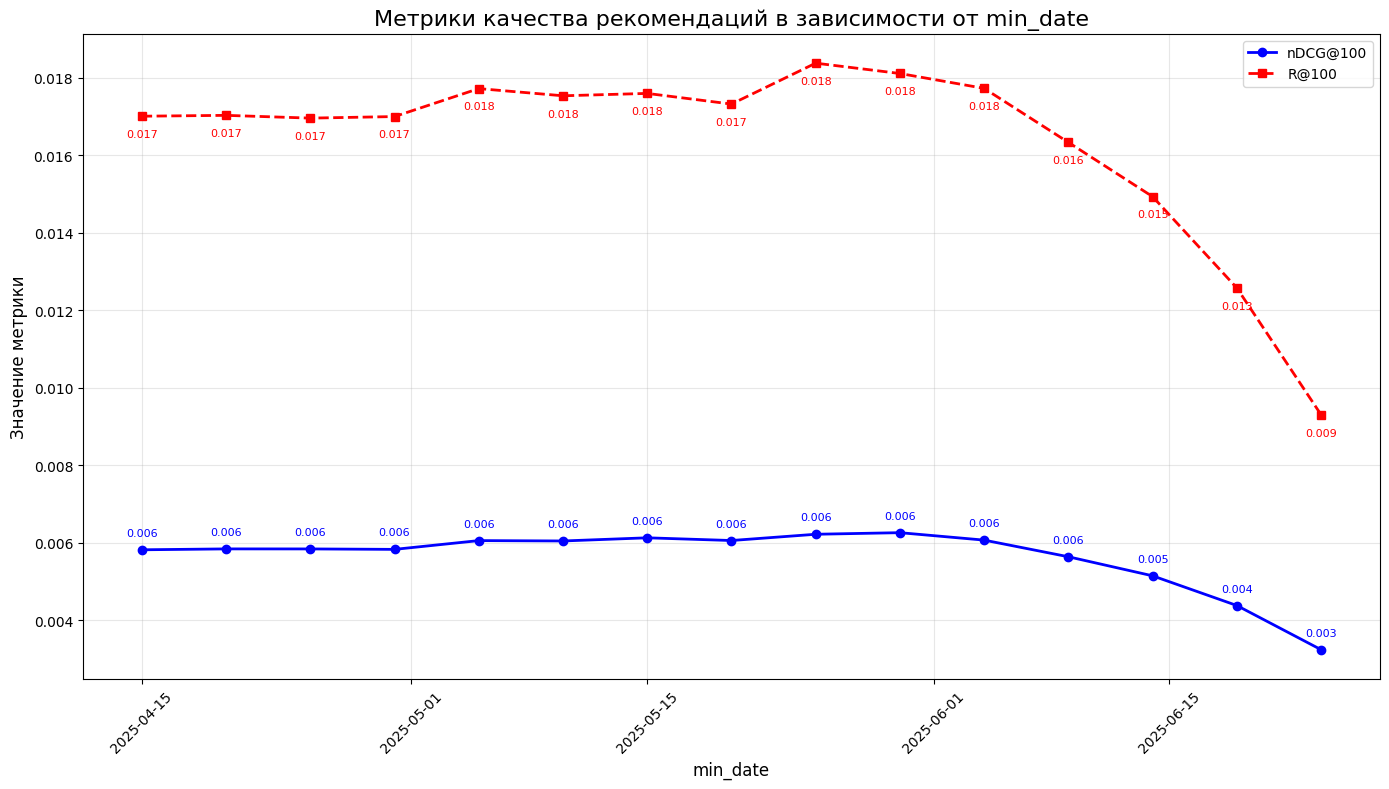


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-04-15	0.00582	0.01701
2025-04-20	0.00584	0.01703
2025-04-25	0.00584	0.01696
2025-04-30	0.00583	0.01700
2025-05-05	0.00606	0.01772
2025-05-10	0.00605	0.01754
2025-05-15	0.00613	0.01760
2025-05-20	0.00606	0.01732
2025-05-25	0.00622	0.01838
2025-05-30	0.00626	0.01811
2025-06-04	0.00607	0.01773
2025-06-09	0.00564	0.01634
2025-06-14	0.00515	0.01494
2025-06-19	0.00438	0.01258
2025-06-24	0.00324	0.00931


In [7]:
start_date = datetime(2025, 4, 15)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []
# Проходим по всем датам
for min_date in date_range:
    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")
    
    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)
    
    # Ваш код с текущей датой
    orders_df = (
        pl.scan_parquet(order_files, extra_columns='ignore')
        .filter((pl.col('created_timestamp') > min_date_pl) &
                (pl.col('created_timestamp') < max_date)) 
        .select(['user_id', 'item_id', 'last_status'])
        .collect()
    )
    
    popular_items = (
        orders_df.filter(pl.col('last_status') == 'delivered_orders')
        .get_column('item_id')
        .value_counts(sort=True)
        .head(100)
        .get_column('item_id')
        .to_list()
    )
    
    candidates = orders_df.select(pl.col('user_id').unique())
    candidates = candidates.with_columns(
        pl.lit(popular_items).alias('item_id')
    ).to_pandas()
    
    aggregated_results, _ = validate_recommendations(candidates, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")

Итог: дополняем популярными товарами за прошедший месяц

## Last favorite

In [29]:
df = pl.read_parquet(tracker_files[0])

In [31]:
df['action_type'].unique()

action_type
str
"""view_description"""
"""to_cart"""
"""page_view"""
"""unfavorite"""
"""remove"""
"""review_view"""
"""favorite"""


### 'to_cart'

In [ ]:
min_date = pl.datetime(2025, 6, 1)
max_date = pl.datetime(2025, 7, 1)
all_dfs = []
for i in tqdm(range(len(temp_files)-1, -1, -1), desc='Gen'):
    file_path = temp_files[i]

    df = pl.read_parquet(
        file_path, 
        columns=['user_id', 'item_id', 'action_type', 'timestamp']
    ).filter(
        pl.col('action_type').is_in(['to_cart']) & 
        (pl.col('timestamp') > min_date) &
        (pl.col('timestamp') < max_date)
    )
    all_dfs.append(df)

tracker_df_to_cart = pl.concat(all_dfs)

Gen: 100%|██████████| 57/57 [00:07<00:00,  7.68it/s]


In [9]:
cart_candidates = (
    tracker_df_to_cart
    .group_by("user_id")
    .agg([
        pl.col("item_id").alias("item_id")
    ]).select(['user_id', 'item_id'])
).to_pandas()

In [10]:
cart_candidates

,user_id,item_id
0,2500090,"[158711629, 165938954, 84165087, 258947529, 25..."
1,4444541,"[263451559, 266672942, 210327140, 320102963]"
2,330071,"[180668686, 310192824, 5289240, 145853555, 260..."
3,887830,"[152349005, 209452749, 161826086, 77696741]"
4,3772240,"[250283629, 126259444]"
...,...,...
685776,4777330,"[277381692, 243760045, 182448986, 6624604, 266..."
685777,1719630,"[223111672, 160220403, 82684775, 323326763]"
685778,4100551,"[83998232, 23887650, 229230710, 16486645, 1858..."
685779,4350131,"[254651986, 209015391, 29851879, 153219406, 21..."


In [14]:
test_orders_true

,user_id,item_ids
0,1984841,[166327353]
1,470191,"[178529238, 281117622, 156001453, 201454148, 8..."
2,2097701,"[102207234, 52837369]"
3,3064920,[181492694]
4,5030611,"[202577110, 268553095]"
...,...,...
217700,2733920,[221878094]
217701,4071451,"[11941701, 197181506, 297987038, 51155066, 207..."
217702,2345920,"[210922721, 166917526]"
217703,2660521,"[148336213, 111057653, 249153349]"


In [ ]:
aggregated_results, _ = validate_recommendations(cart_candidates, test_orders_true, k_values=[100])

In [16]:
aggregated_results

{'P@100': np.float64(0.01846130635459029),
 'R@100': np.float64(0.1121011035963805),
 'HR@100': np.float64(0.167905262521902),
 'MRR@100': np.float64(0.039894942788069786),
 'nDCG@100': np.float64(0.05080232664166562)}

Обрабатываю дату: 2025-05-01


Gen: 100%|██████████| 57/57 [00:07<00:00,  7.97it/s]


nDCG@100 = 0.04420
R@100 = 0.11747
Обрабатываю дату: 2025-05-06


Gen: 100%|██████████| 57/57 [00:06<00:00,  8.22it/s]


nDCG@100 = 0.04472
R@100 = 0.11633
Обрабатываю дату: 2025-05-11


Gen: 100%|██████████| 57/57 [00:07<00:00,  8.08it/s]


nDCG@100 = 0.04503
R@100 = 0.11489
Обрабатываю дату: 2025-05-16


Gen: 100%|██████████| 57/57 [00:07<00:00,  7.92it/s]


nDCG@100 = 0.04558
R@100 = 0.11317
Обрабатываю дату: 2025-05-21


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.89it/s]


nDCG@100 = 0.04594
R@100 = 0.11070
Обрабатываю дату: 2025-05-26


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


nDCG@100 = 0.04625
R@100 = 0.10736
Обрабатываю дату: 2025-05-31


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.96it/s]


nDCG@100 = 0.04634
R@100 = 0.10314
Обрабатываю дату: 2025-06-05


Gen: 100%|██████████| 57/57 [00:11<00:00,  5.03it/s]


nDCG@100 = 0.04610
R@100 = 0.09790
Обрабатываю дату: 2025-06-10


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.99it/s]


nDCG@100 = 0.04560
R@100 = 0.09120
Обрабатываю дату: 2025-06-15


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.83it/s]


nDCG@100 = 0.04413
R@100 = 0.08180
Обрабатываю дату: 2025-06-20


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.99it/s]


nDCG@100 = 0.04113
R@100 = 0.06963
Обрабатываю дату: 2025-06-25


Gen: 100%|██████████| 57/57 [00:11<00:00,  5.04it/s]


nDCG@100 = 0.03429
R@100 = 0.05054


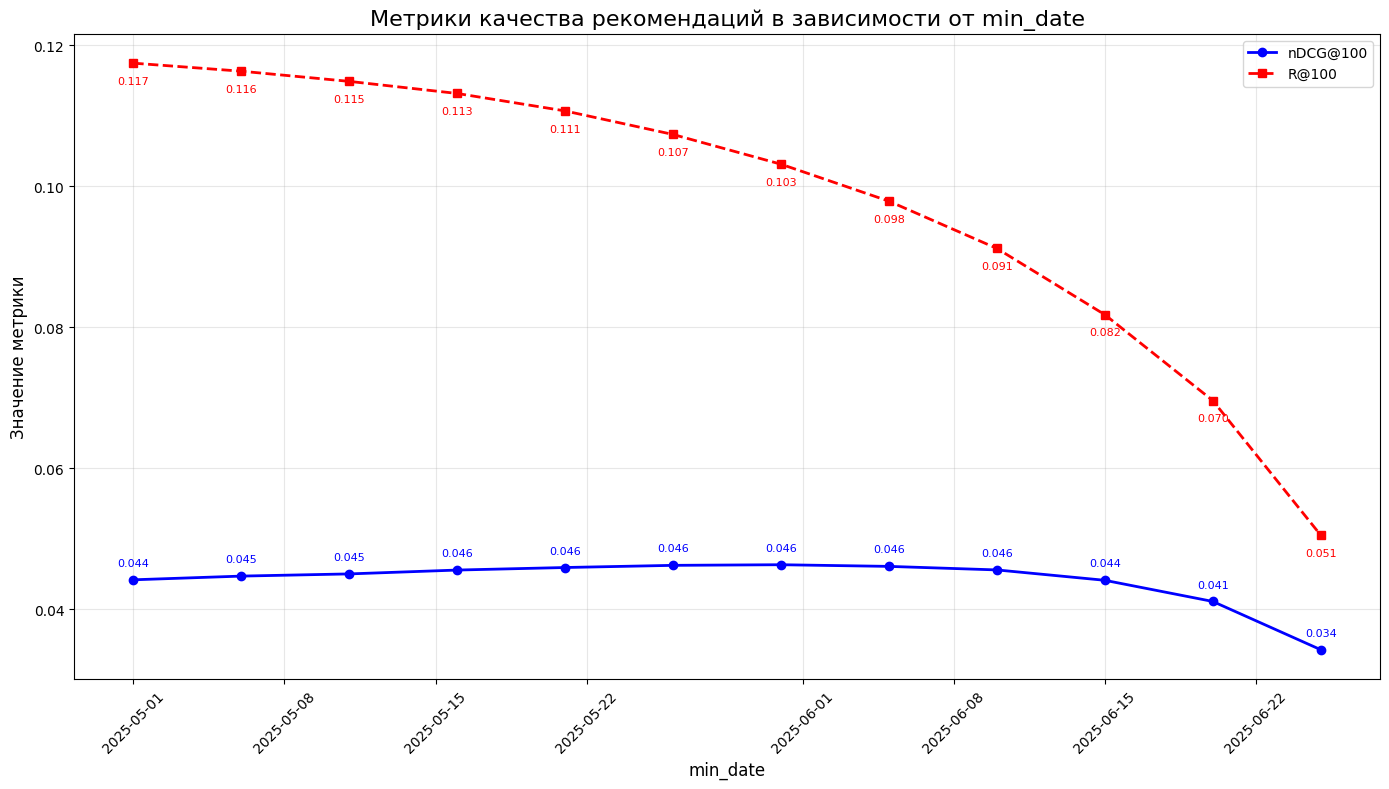


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-05-01	0.04420	0.11747
2025-05-06	0.04472	0.11633
2025-05-11	0.04503	0.11489
2025-05-16	0.04558	0.11317
2025-05-21	0.04594	0.11070
2025-05-26	0.04625	0.10736
2025-05-31	0.04634	0.10314
2025-06-05	0.04610	0.09790
2025-06-10	0.04560	0.09120
2025-06-15	0.04413	0.08180
2025-06-20	0.04113	0.06963
2025-06-25	0.03429	0.05054


In [8]:
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []
# Проходим по всем датам
for min_date in date_range:
    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")
    
    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)
    
    # Ваш код с текущей датой
    max_date = pl.datetime(2025, 7, 1)
    all_dfs = []
    for i in tqdm(range(len(temp_files)-1, -1, -1), desc='Gen'):
        file_path = temp_files[i]

        df = pl.read_parquet(
            file_path, 
            columns=['user_id', 'item_id', 'action_type', 'timestamp']
        ).filter(
            pl.col('action_type').is_in(['to_cart']) & 
            (pl.col('timestamp') > min_date_pl) &
            (pl.col('timestamp') < max_date)
        )
        all_dfs.append(df)

    tracker_df_to_cart = pl.concat(all_dfs)

    cart_candidates = (
    tracker_df_to_cart
        .group_by("user_id")
        .agg([
            pl.col("item_id").alias("item_id")
        ]).select(['user_id', 'item_id'])
        ).to_pandas()   
    
    aggregated_results, _ = validate_recommendations(cart_candidates, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")

### 'favorive'

Обрабатываю дату: 2025-05-01


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.87it/s]


nDCG@100 = 0.01364
R@100 = 0.03750
Обрабатываю дату: 2025-05-06


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.80it/s]


nDCG@100 = 0.01385
R@100 = 0.03748
Обрабатываю дату: 2025-05-11


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.87it/s]


nDCG@100 = 0.01399
R@100 = 0.03711
Обрабатываю дату: 2025-05-16


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.83it/s]


nDCG@100 = 0.01411
R@100 = 0.03664
Обрабатываю дату: 2025-05-21


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.86it/s]


nDCG@100 = 0.01415
R@100 = 0.03579
Обрабатываю дату: 2025-05-26


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.83it/s]


nDCG@100 = 0.01421
R@100 = 0.03473
Обрабатываю дату: 2025-05-31


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.85it/s]


nDCG@100 = 0.01409
R@100 = 0.03318
Обрабатываю дату: 2025-06-05


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.88it/s]


nDCG@100 = 0.01394
R@100 = 0.03147
Обрабатываю дату: 2025-06-10


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.82it/s]


nDCG@100 = 0.01358
R@100 = 0.02914
Обрабатываю дату: 2025-06-15


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.84it/s]


nDCG@100 = 0.01279
R@100 = 0.02580
Обрабатываю дату: 2025-06-20


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.88it/s]


nDCG@100 = 0.01162
R@100 = 0.02154
Обрабатываю дату: 2025-06-25


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.90it/s]


nDCG@100 = 0.00934
R@100 = 0.01521


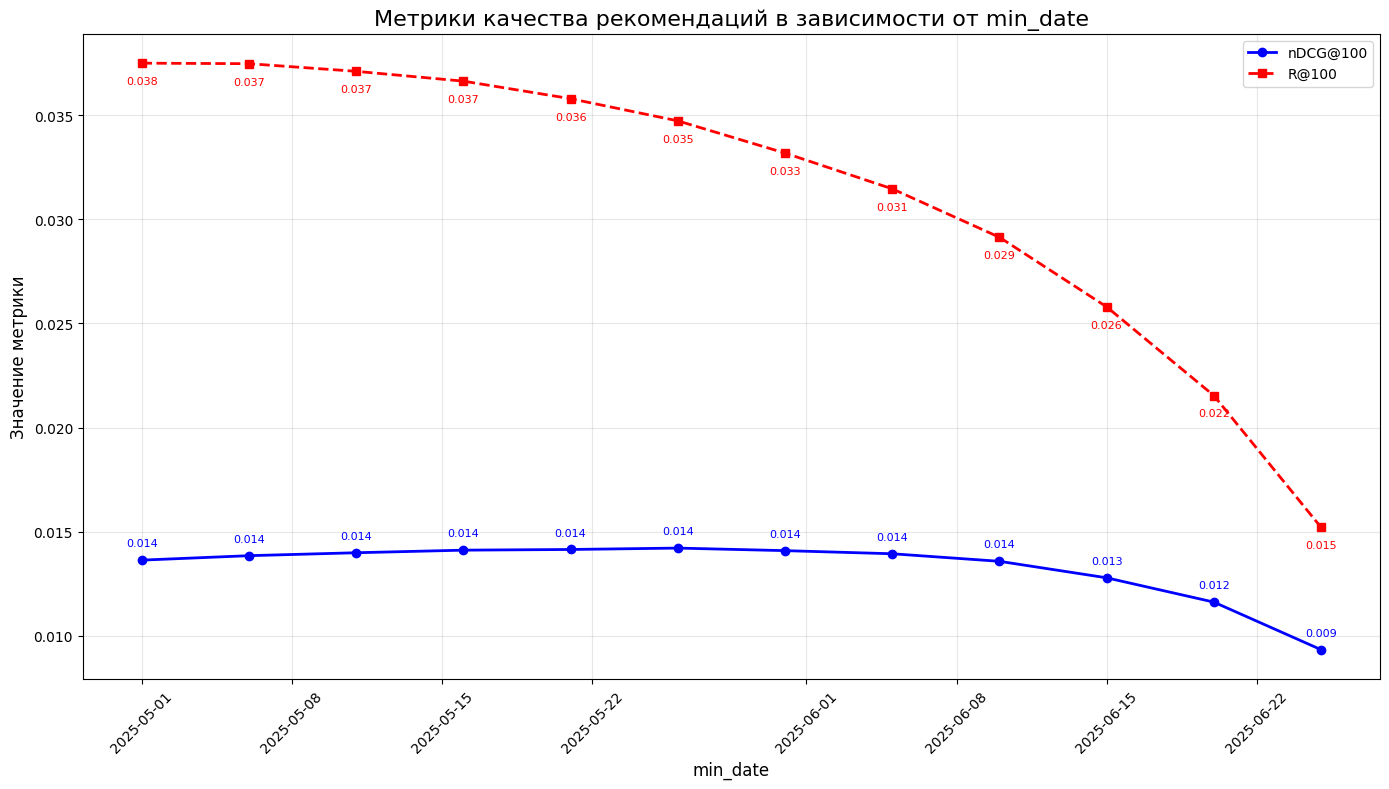


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-05-01	0.01364	0.03750
2025-05-06	0.01385	0.03748
2025-05-11	0.01399	0.03711
2025-05-16	0.01411	0.03664
2025-05-21	0.01415	0.03579
2025-05-26	0.01421	0.03473
2025-05-31	0.01409	0.03318
2025-06-05	0.01394	0.03147
2025-06-10	0.01358	0.02914
2025-06-15	0.01279	0.02580
2025-06-20	0.01162	0.02154
2025-06-25	0.00934	0.01521


In [9]:
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []
# Проходим по всем датам
for min_date in date_range:
    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")
    
    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)

    all_dfs = []
    for i in tqdm(range(len(temp_files)-1, -1, -1), desc='Gen'):
        file_path = temp_files[i]

        df = pl.read_parquet(
            file_path, 
            columns=['user_id', 'item_id', 'action_type', 'timestamp']
        ).filter(
            pl.col('action_type').is_in(['favorite']) & 
            (pl.col('timestamp') > min_date_pl) &
            (pl.col('timestamp') < max_date)
        )
        all_dfs.append(df)

    tracker_df_to_cart = pl.concat(all_dfs)

    cart_candidates = (
    tracker_df_to_cart
        .group_by("user_id")
        .agg([
            pl.col("item_id").alias("item_id")
        ]).select(['user_id', 'item_id'])
        ).to_pandas()   
    
    aggregated_results, _ = validate_recommendations(cart_candidates, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")

### view_description

Обрабатываю дату: 2025-05-01


Gen:   0%|          | 0/57 [00:00<?, ?it/s]

Gen: 100%|██████████| 57/57 [00:12<00:00,  4.51it/s]


nDCG@100 = 0.02456
R@100 = 0.08810
Обрабатываю дату: 2025-05-06


Gen: 100%|██████████| 57/57 [00:14<00:00,  4.01it/s]


nDCG@100 = 0.02513
R@100 = 0.08921
Обрабатываю дату: 2025-05-11


Gen: 100%|██████████| 57/57 [00:12<00:00,  4.45it/s]


nDCG@100 = 0.02568
R@100 = 0.09017
Обрабатываю дату: 2025-05-16


Gen: 100%|██████████| 57/57 [00:12<00:00,  4.56it/s]


nDCG@100 = 0.02638
R@100 = 0.09153
Обрабатываю дату: 2025-05-21


Gen: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]


nDCG@100 = 0.02703
R@100 = 0.09241
Обрабатываю дату: 2025-05-26


Gen: 100%|██████████| 57/57 [00:14<00:00,  4.04it/s]


nDCG@100 = 0.02762
R@100 = 0.09249
Обрабатываю дату: 2025-05-31


Gen: 100%|██████████| 57/57 [00:13<00:00,  4.11it/s]


nDCG@100 = 0.02818
R@100 = 0.09245
Обрабатываю дату: 2025-06-05


Gen: 100%|██████████| 57/57 [00:14<00:00,  4.06it/s]


nDCG@100 = 0.02876
R@100 = 0.09230
Обрабатываю дату: 2025-06-10


Gen: 100%|██████████| 57/57 [00:12<00:00,  4.51it/s]


nDCG@100 = 0.02923
R@100 = 0.09100
Обрабатываю дату: 2025-06-15


Gen: 100%|██████████| 57/57 [00:14<00:00,  3.93it/s]


nDCG@100 = 0.02886
R@100 = 0.08622
Обрабатываю дату: 2025-06-20


Gen: 100%|██████████| 57/57 [00:10<00:00,  5.47it/s]


nDCG@100 = 0.02787
R@100 = 0.07911
Обрабатываю дату: 2025-06-25


Gen: 100%|██████████| 57/57 [00:13<00:00,  4.32it/s]


nDCG@100 = 0.02392
R@100 = 0.06189


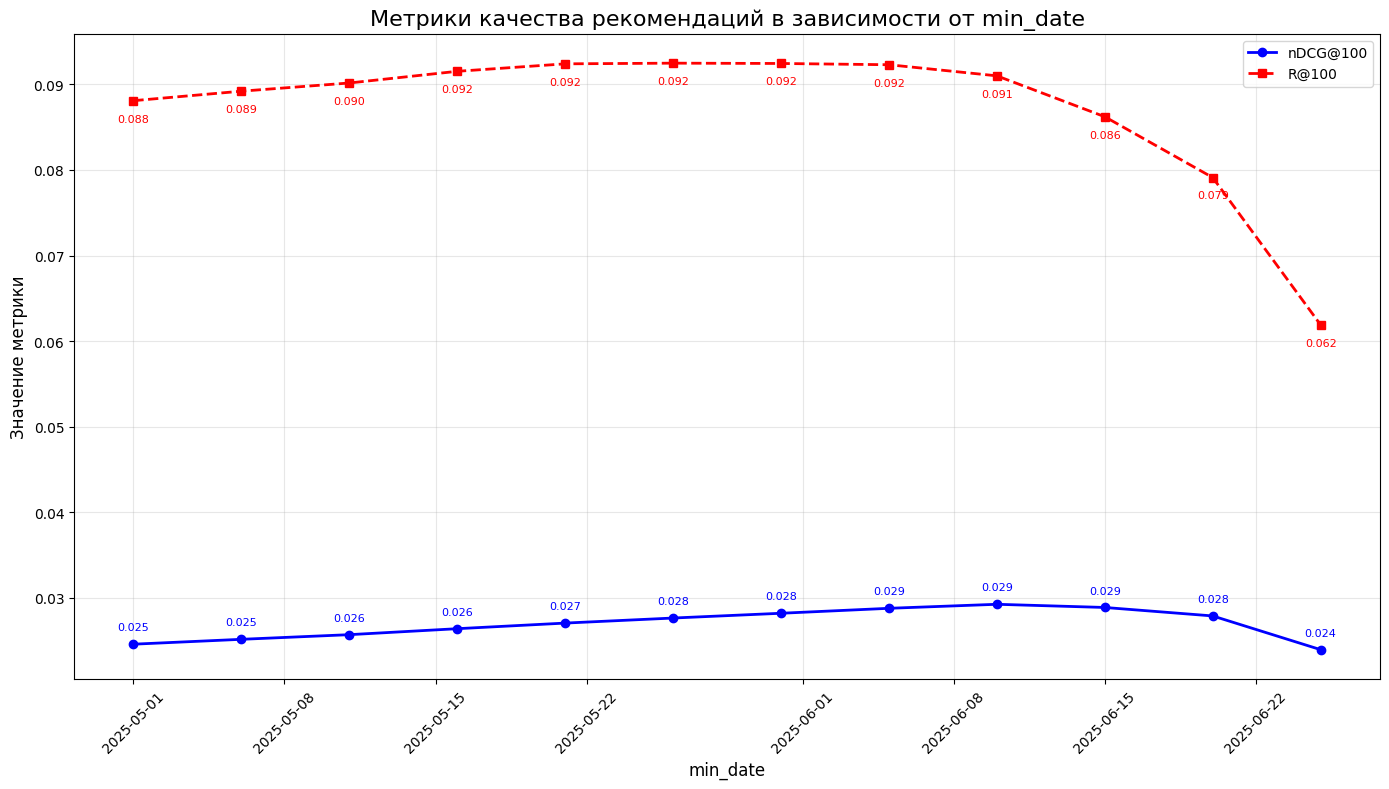


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-05-01	0.02456	0.08810
2025-05-06	0.02513	0.08921
2025-05-11	0.02568	0.09017
2025-05-16	0.02638	0.09153
2025-05-21	0.02703	0.09241
2025-05-26	0.02762	0.09249
2025-05-31	0.02818	0.09245
2025-06-05	0.02876	0.09230
2025-06-10	0.02923	0.09100
2025-06-15	0.02886	0.08622
2025-06-20	0.02787	0.07911
2025-06-25	0.02392	0.06189


In [10]:
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []
# Проходим по всем датам
for min_date in date_range:
    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")
    
    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)

    all_dfs = []
    for i in tqdm(range(len(temp_files)-1, -1, -1), desc='Gen'):
        file_path = temp_files[i]

        df = pl.read_parquet(
            file_path, 
            columns=['user_id', 'item_id', 'action_type', 'timestamp']
        ).filter(
            pl.col('action_type').is_in(['view_description']) & 
            (pl.col('timestamp') > min_date_pl) &
            (pl.col('timestamp') < max_date)
        )
        all_dfs.append(df)

    tracker_df_to_cart = pl.concat(all_dfs)

    cart_candidates = (
    tracker_df_to_cart
        .group_by("user_id")
        .agg([
            pl.col("item_id").alias("item_id")
        ]).select(['user_id', 'item_id'])
        ).to_pandas()   
    
    aggregated_results, _ = validate_recommendations(cart_candidates, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")

### "review_view"

Обрабатываю дату: 2025-05-01


Gen:   0%|          | 0/57 [00:00<?, ?it/s]

Gen: 100%|██████████| 57/57 [00:13<00:00,  4.37it/s]


nDCG@100 = 0.01707
R@100 = 0.05403
Обрабатываю дату: 2025-05-06


Gen: 100%|██████████| 57/57 [00:14<00:00,  4.03it/s]


nDCG@100 = 0.01730
R@100 = 0.05404
Обрабатываю дату: 2025-05-11


Gen: 100%|██████████| 57/57 [00:14<00:00,  4.02it/s]


nDCG@100 = 0.01757
R@100 = 0.05414
Обрабатываю дату: 2025-05-16


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.93it/s]


nDCG@100 = 0.01788
R@100 = 0.05426
Обрабатываю дату: 2025-05-21


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.93it/s]


nDCG@100 = 0.01819
R@100 = 0.05405
Обрабатываю дату: 2025-05-26


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.82it/s]


nDCG@100 = 0.01840
R@100 = 0.05342
Обрабатываю дату: 2025-05-31


Gen: 100%|██████████| 57/57 [00:12<00:00,  4.68it/s]


nDCG@100 = 0.01861
R@100 = 0.05269
Обрабатываю дату: 2025-06-05


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.75it/s]


nDCG@100 = 0.01873
R@100 = 0.05121
Обрабатываю дату: 2025-06-10


Gen: 100%|██████████| 57/57 [00:11<00:00,  4.77it/s]


nDCG@100 = 0.01868
R@100 = 0.04894
Обрабатываю дату: 2025-06-15


Gen: 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]


nDCG@100 = 0.01832
R@100 = 0.04529
Обрабатываю дату: 2025-06-20


Gen: 100%|██████████| 57/57 [00:10<00:00,  5.46it/s]


nDCG@100 = 0.01717
R@100 = 0.03925
Обрабатываю дату: 2025-06-25


Gen: 100%|██████████| 57/57 [00:09<00:00,  6.12it/s]


nDCG@100 = 0.01430
R@100 = 0.02892


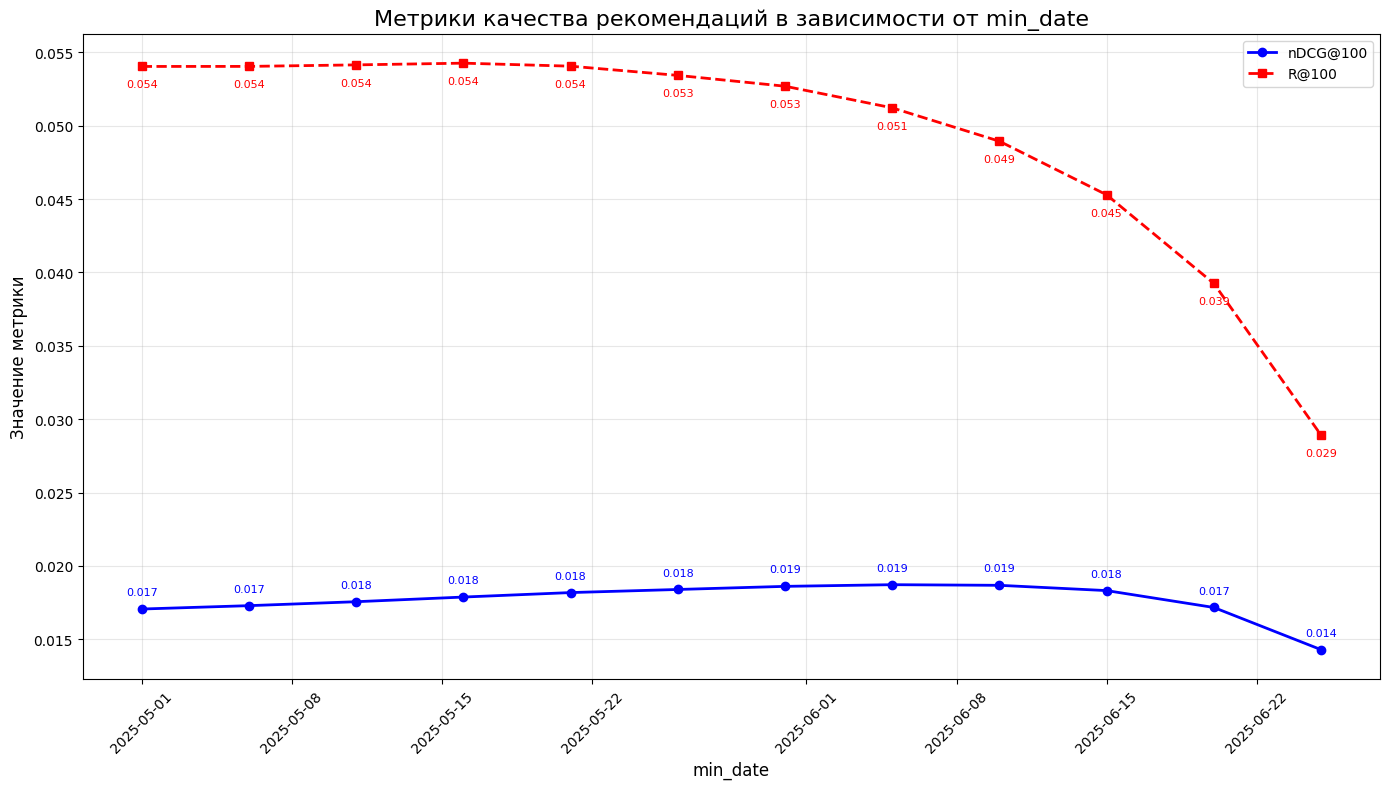


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-05-01	0.01707	0.05403
2025-05-06	0.01730	0.05404
2025-05-11	0.01757	0.05414
2025-05-16	0.01788	0.05426
2025-05-21	0.01819	0.05405
2025-05-26	0.01840	0.05342
2025-05-31	0.01861	0.05269
2025-06-05	0.01873	0.05121
2025-06-10	0.01868	0.04894
2025-06-15	0.01832	0.04529
2025-06-20	0.01717	0.03925
2025-06-25	0.01430	0.02892


In [11]:
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []
# Проходим по всем датам
for min_date in date_range:
    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")
    
    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)

    all_dfs = []
    for i in tqdm(range(len(temp_files)-1, -1, -1), desc='Gen'):
        file_path = temp_files[i]

        df = pl.read_parquet(
            file_path, 
            columns=['user_id', 'item_id', 'action_type', 'timestamp']
        ).filter(
            pl.col('action_type').is_in(['review_view']) & 
            (pl.col('timestamp') > min_date_pl) &
            (pl.col('timestamp') < max_date)
        )
        all_dfs.append(df)

    tracker_df_to_cart = pl.concat(all_dfs)

    cart_candidates = (
    tracker_df_to_cart
        .group_by("user_id")
        .agg([
            pl.col("item_id").alias("item_id")
        ]).select(['user_id', 'item_id'])
        ).to_pandas()   
    
    aggregated_results, _ = validate_recommendations(cart_candidates, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")

## processed_orders

Обрабатываю дату: 2025-05-01


Gen: 100%|██████████| 33/33 [00:00<00:00, 51.41it/s]


nDCG@100 = 0.00677
R@100 = 0.00879
Обрабатываю дату: 2025-05-06


Gen: 100%|██████████| 33/33 [00:00<00:00, 51.80it/s]


nDCG@100 = 0.00677
R@100 = 0.00879
Обрабатываю дату: 2025-05-11


Gen: 100%|██████████| 33/33 [00:00<00:00, 53.75it/s]


nDCG@100 = 0.00677
R@100 = 0.00879
Обрабатываю дату: 2025-05-16


Gen: 100%|██████████| 33/33 [00:00<00:00, 52.87it/s]


nDCG@100 = 0.00678
R@100 = 0.00878
Обрабатываю дату: 2025-05-21


Gen: 100%|██████████| 33/33 [00:00<00:00, 58.12it/s]


nDCG@100 = 0.00678
R@100 = 0.00877
Обрабатываю дату: 2025-05-26


Gen: 100%|██████████| 33/33 [00:00<00:00, 55.22it/s]


nDCG@100 = 0.00680
R@100 = 0.00877
Обрабатываю дату: 2025-05-31


Gen: 100%|██████████| 33/33 [00:00<00:00, 55.62it/s]


nDCG@100 = 0.00681
R@100 = 0.00877
Обрабатываю дату: 2025-06-05


Gen: 100%|██████████| 33/33 [00:00<00:00, 54.84it/s]


nDCG@100 = 0.00681
R@100 = 0.00875
Обрабатываю дату: 2025-06-10


Gen: 100%|██████████| 33/33 [00:00<00:00, 52.51it/s]


nDCG@100 = 0.00684
R@100 = 0.00873
Обрабатываю дату: 2025-06-15


Gen: 100%|██████████| 33/33 [00:00<00:00, 54.39it/s]


nDCG@100 = 0.00683
R@100 = 0.00863
Обрабатываю дату: 2025-06-20


Gen: 100%|██████████| 33/33 [00:00<00:00, 54.73it/s]


nDCG@100 = 0.00661
R@100 = 0.00819
Обрабатываю дату: 2025-06-25


Gen: 100%|██████████| 33/33 [00:00<00:00, 56.52it/s]


nDCG@100 = 0.00592
R@100 = 0.00701


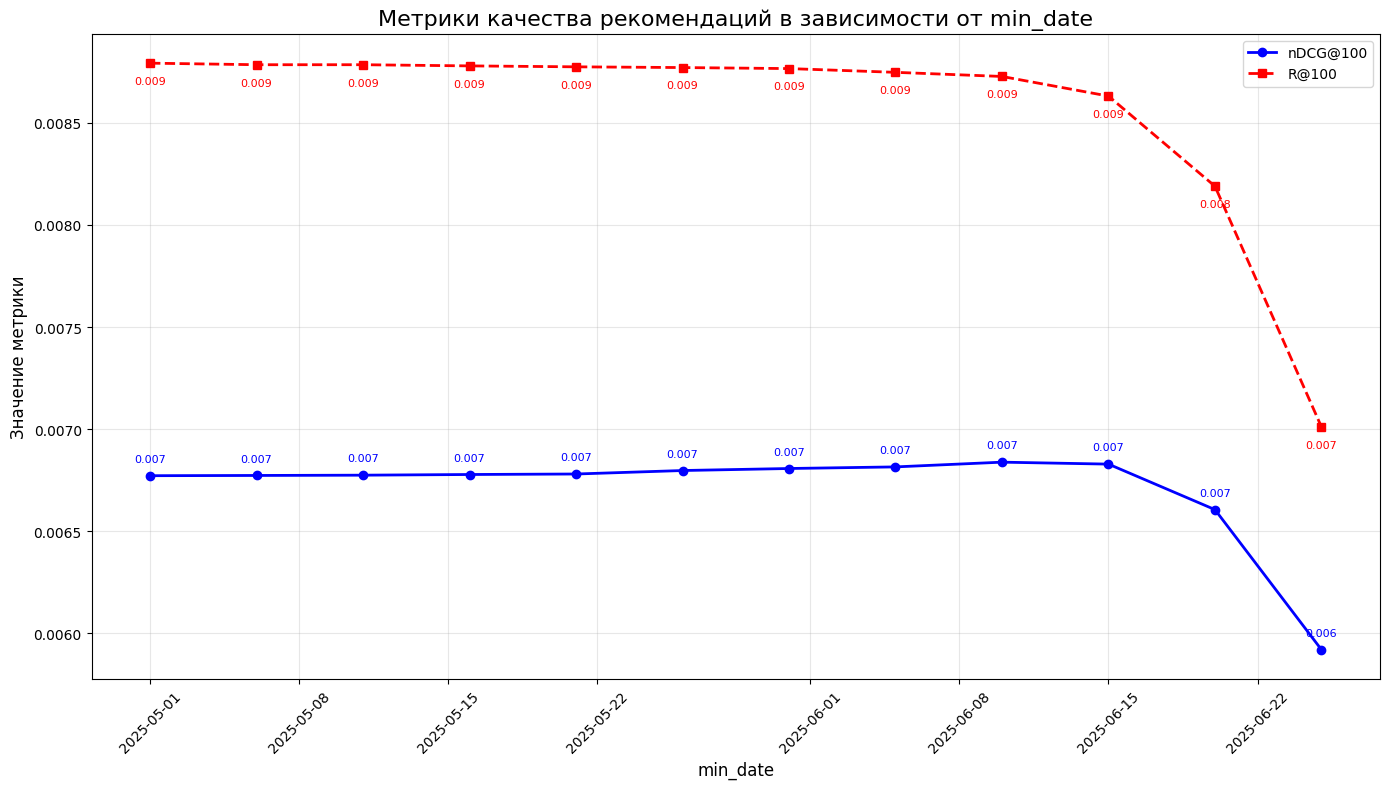


Результаты:
Дата			nDCG@100	R@100
--------------------------------------------------
2025-05-01	0.00677	0.00879
2025-05-06	0.00677	0.00879
2025-05-11	0.00677	0.00879
2025-05-16	0.00678	0.00878
2025-05-21	0.00678	0.00877
2025-05-26	0.00680	0.00877
2025-05-31	0.00681	0.00877
2025-06-05	0.00681	0.00875
2025-06-10	0.00684	0.00873
2025-06-15	0.00683	0.00863
2025-06-20	0.00661	0.00819
2025-06-25	0.00592	0.00701


In [5]:
start_date = datetime(2025, 5, 1)
end_date = datetime(2025, 6, 25)
max_date = pl.datetime(2025, 7, 1)

# Создаем список дат с шагом 5 дней
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date)
    current_date += timedelta(days=5)

# Списки для хранения результатов
min_dates = []
ndcg_scores = []
recall_scores = []

for min_date in date_range:

    print(f"Обрабатываю дату: {min_date.strftime('%Y-%m-%d')}")

    # Преобразуем datetime в polars datetime
    min_date_pl = pl.datetime(min_date.year, min_date.month, min_date.day)

    all_dfs = []
    for i in tqdm(range(len(order_files)-1, -1, -1), desc='Gen'):
        file_path = order_files[i]


        df = pl.read_parquet(
        file_path, 
        columns=['user_id', 'item_id', 'created_timestamp', 'last_status', 'last_status_timestamp']
        ).filter((pl.col('created_timestamp') > min_date_pl) & 
                    (pl.col('created_timestamp') < max_date) &
                (pl.col('last_status') == 'proccesed_orders'))

        all_dfs.append(df)

    processed_orders = pl.concat(all_dfs)

    candidate_processed = (
        processed_orders
        .group_by("user_id")
        .agg([
            pl.col("item_id").alias("item_id")
        ]).select(['user_id', 'item_id'])
        ).to_pandas() 
    
    aggregated_results, _ = validate_recommendations(candidate_processed, test_orders_true, k_values=[100])
    
    # Сохраняем результаты
    min_dates.append(min_date)
    ndcg_scores.append(aggregated_results['nDCG@100'])
    recall_scores.append(aggregated_results['R@100'])
    print(f"nDCG@100 = {aggregated_results['nDCG@100']:.5f}")
    print(f"R@100 = {aggregated_results['R@100']:.5f}")
# Строим график с двумя линиями
plt.figure(figsize=(14, 8))

# Первая линия - nDCG@100
line1, = plt.plot(min_dates, ndcg_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=6, color='blue', label='nDCG@100')

# Вторая линия - R@100
line2, = plt.plot(min_dates, recall_scores, marker='s', linestyle='--', 
                 linewidth=2, markersize=6, color='red', label='R@100')

plt.title('Метрики качества рекомендаций в зависимости от min_date', fontsize=16)
plt.xlabel('min_date', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавляем аннотации для nDCG@100
for i, (date, score) in enumerate(zip(min_dates, ndcg_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8,
                color='blue')

# Добавляем аннотации для R@100
for i, (date, score) in enumerate(zip(min_dates, recall_scores)):
    plt.annotate(f'{score:.3f}', (date, score), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                fontsize=8,
                color='red')

plt.show()

# Выводим таблицу результатов
print("\nРезультаты:")
print("Дата\t\t\tnDCG@100\tR@100")
print("-" * 50)
for date, ndcg, recall in zip(min_dates, ndcg_scores, recall_scores):
    print(f"{date.strftime('%Y-%m-%d')}\t{ndcg:.5f}\t{recall:.5f}")
